# Generic Case

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import tomas as tm

load and analyze data with `scanpy`

In [2]:
adata = sc.read_h5ad('prepareForRepo/pbmc_dbl/adata.h5ad')

## Computational doublet detection

load putative doublets detected by computational doublet detection methods. Here we use `R` package [DoubletCollection](https://github.com/xnnba1984/DoubletCollection), which integrates multiple computational doublet-detection methods, for doublet detection. The benchmarking of different doublet detection methods and execution of `DoubletCollection` package could see Dobulet Detection tutorial.

In [3]:
dbl_pred = pd.read_csv('prepareForRepo/pbmc_dbl/dbl_pred.txt',header=None,index_col=None)
dbl_pred.head(3)

,0
0,GACTAACCAGTTAACC-1
1,CGACCTTTCAGATAAG-1
2,GACACGCCAAGAGGCT-1


In [4]:
adata.obs['droplet_type'] = 'Homotypic'
adata.obs.loc[np.ravel(dbl_pred),'droplet_type'] = 'Heterotypic'

Clutering putative singlets to identify cell types following the [clutering tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) of `scanpy`. We recommand not performing global normalization step.

## Homotypic droplet population identification

In [5]:
sc.settings.verbosity = 3            
sc.settings.set_figure_params(dpi=60, facecolor='white')

filtered out 2878 genes that are detected in less than 1 cells
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['n_counts']
    sparse input is densified and may lead to high memory use
/home/qy/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'droplet_type' as categorical
    finished (0:00:07)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:10)
computing UMAP
    f

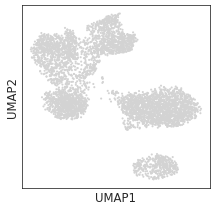

In [6]:
adata_psgl = adata[adata.obs['droplet_type']=='Homotypic'].copy()

sc.pp.filter_cells(adata_psgl, min_genes=1)
sc.pp.filter_genes(adata_psgl, min_cells=1)

sc.pp.log1p(adata_psgl)
sc.pp.highly_variable_genes(adata_psgl, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_psgl.raw = adata_psgl
adata_psgl = adata_psgl[:, adata_psgl.var.highly_variable]
sc.pp.regress_out(adata_psgl, ['n_counts']) ##
sc.pp.scale(adata_psgl, max_value=10)
sc.tl.pca(adata_psgl, svd_solver='arpack')
sc.pp.neighbors(adata_psgl, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_psgl)
sc.pl.umap(adata_psgl)


Markers are from the [clutering tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) of `scanpy`

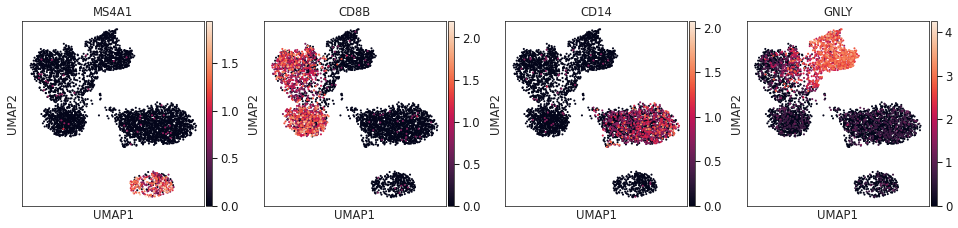

In [7]:
sc.pl.umap(adata_psgl, color=['MS4A1', 'CD8B', 'CD14', 'GNLY'])


running Leiden clustering
    finished: found 4 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


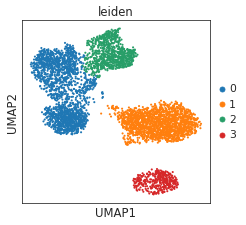

In [8]:
sc.tl.leiden(adata_psgl, resolution=0.12, random_state=1)
sc.pl.umap(adata_psgl, color=['leiden'])

(optional) Annotate cell clusters with domain knowledge of cell-type-specific transcriptomic markers: MS4A1-B cells, CD8B-CD8 T cells, CD14-classical(CD14+) monocytes, GNLY-mNK cells.  

Note: This step is optional. `TOMAS` could aslo be applied to infer total-mRNA ratioes between identified cell clusters.

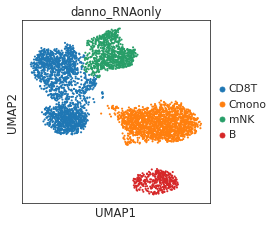

In [9]:
ct_mapper = {}
ct_mapper['0']='CD8T'  # CD8B
ct_mapper['1']='Cmono' # CD14
ct_mapper['2']='mNK'   # GNLY
ct_mapper['3']='B'     # MS4A1

adata_psgl.obs['danno_RNAonly'] = pd.Categorical([ct_mapper[g] for g in adata_psgl.obs['leiden']],
                                                               categories=ct_mapper.values())

sc.pl.umap(adata_psgl, color=['danno_RNAonly'])

**Key**: save identified cell cluters/types as mandatory inputs for `TOMAS`

In [10]:
adata.obs['danno_RNAonly'] = 'unknown'
adata.obs.loc[adata_psgl.obs_names,'danno_RNAonly'] = adata_psgl.obs['danno_RNAonly'].values


## Hetero doublets identification and refinement 

Detect genes specifically highly expressed in each cell type. 

In [11]:
sc.tl.rank_genes_groups(adata_psgl, 'danno_RNAonly', method='wilcoxon')
degene_sorted = tm.auxi.extract_specific_genes(adata_psgl, 'danno_RNAonly')


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


Identified heterotypic doublets expressing specific genes of both component cell types. 

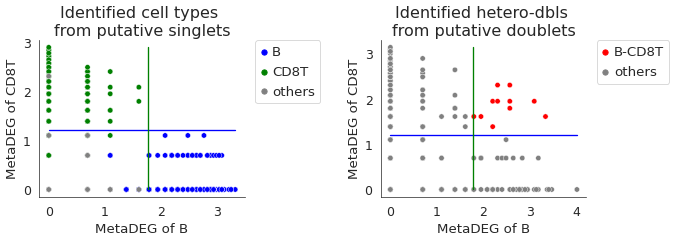

In [12]:
ct_pair = ['B','CD8T']
d_groupby = 'droplet_type'
ct_groupby = 'danno_RNAonly'

dbl_candidate = tm.auxi.inferHeteroDbl(adata, 
                                       ct_pair, 
                                       d_groupby, 
                                       ct_groupby,
                                       de_sorted = degene_sorted)

**Key**: save refined heterotypic doublet labels as mandatory inputs for `TOMAS`

In [13]:
adata.obs.loc[dbl_candidate,'danno_RNAonly'] = 'B_CD8T'